In [1]:
!pip install seaborn==0.11.1
!pip install tensorflow==2.7.0

import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

     |████████████████████████████████| 207.1 MB 22 kB/s  eta 0:00:011   |███████▏                        | 46.6 MB 338 kB/s eta 0:07:55     |███████████                     | 70.5 MB 779 kB/s eta 0:02:56
     |████████████████████████████████| 1.3 MB 44.1 MB/s eta 0:00:01
     |████████████████████████████████| 463 kB 49.2 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.2
    Uninstalling keras-3.0.2:
      Successfully uninstalled keras-3.0.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


/var/folders/pg/nlr53rvn2kl2yx5730h8mm1w0000gn/T/ipykernel_66388/1017037120.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
rs=123

In [3]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


In [5]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

In [6]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [7]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [8]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [9]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [10]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [11]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [12]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

In [13]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

In [17]:
sns.color_palette('crest')

[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

In [18]:
## WRITE YOUR CODE HERE:

# encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)
# x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)
# embedding_size = 16
# model = RecommenderNet(num_users, num_items, embedding_size)

# //

## - call model.compile() method to set up the loss and optimizer and metrics for the model training, you may use
##  - - tf.keras.losses.MeanSquaredError() as training loss
##  - - keras.optimizers.Adam() as optimizer
##  - - tf.keras.metrics.RootMeanSquaredError() as metric

# Compile the model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_val, y_val),
    verbose=1
)

# Save the model
# model.save("recommender_model.h5") # this needs work

Epoch 1/10
2917/2917 [==============================] - 11s 3ms/step - loss: 0.1361 - root_mean_squared_error: 0.3685 - val_loss: 0.0449 - val_root_mean_squared_error: 0.2106
Epoch 2/10
2917/2917 [==============================] - 9s 3ms/step - loss: 0.0398 - root_mean_squared_error: 0.1979 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1933
Epoch 3/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0282 - root_mean_squared_error: 0.1653 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1622
Epoch 4/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0219 - root_mean_squared_error: 0.1441 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1503
Epoch 5/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.1296 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1420
Epoch 6/10
2917/2917 [==============================] - 8s 3ms/step - loss: 0.0154 - root_mean_squared_error: 0.1179 - val_loss: 

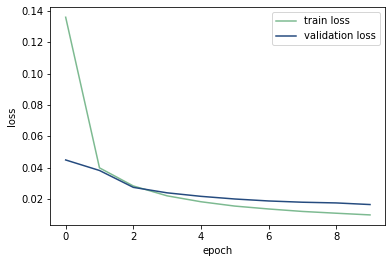

In [23]:
# Plot the train and validation loss
plt.figure()
sns.lineplot(data=history.history, x=history.epoch, y="loss", label="train loss", color=sns.color_palette('crest')[0])
sns.lineplot(data=history.history, x=history.epoch, y="val_loss", label="validation loss", color=sns.color_palette('crest')[-1])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()